<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/R/00_data_preprocessing_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기본 시계열 데이터 전처리 (R 버전)

Python 노트북(결측치/이상치 처리)을 R(tidyverse/zoo/ggplot2)로 변환한 예시입니다.
- 랜덤 워크 형태의 시계열 생성
- 임의 결측치 생성 및 보간(선형)
- 이상치 탐지(IQR, 선택적으로 Z-Score)
- 시각화(이상치 하이라이트)


## 1) 패키지 설치 및 로드 (최초 1회 설치)

In [1]:
options(repos='https://cloud.r-project.org')
pkgs <- c('tidyverse','lubridate','zoo','ggplot2')
to_install <- pkgs[!pkgs %in% installed.packages()[,'Package']]
if (length(to_install) > 0) install.packages(to_install)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(tidyverse)
library(lubridate)
library(zoo)
library(ggplot2)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## 2) 샘플 시계열 데이터 생성

In [3]:
set.seed(42)
dates <- seq.Date(from = as.Date('2022-01-01'), by = 'day', length.out = 100)
values <- cumsum(rnorm(100))  # 누적합 랜덤 워크
df <- tibble(Date = dates, Value = values)
head(df)


Date,Value
<date>,<dbl>
2022-01-01,1.3709584
2022-01-02,0.8062603
2022-01-03,1.1693887
2022-01-04,1.8022513
2022-01-05,2.2065196
2022-01-06,2.1003951


## 3) 결측치 생성 (예시) 및 보간 (선형)

In [4]:
# 임의로 10개 위치를 결측치로 설정
na_idx <- sample(1:nrow(df), size = 10)
df$Value_NA <- df$Value
df$Value_NA[na_idx] <- NA_real_

# 선형 보간 (양끝 extrapolation은 마지막 관측값 유지)
df <- df %>% mutate(Value_Interpolated = na.approx(Value_NA, x = Date, na.rm = FALSE))
sum(is.na(df$Value_Interpolated))  # 남은 결측치 수 확인


[1] 0

## 4) 이상치 탐지 (IQR 방식) 및 선택: Z-Score

In [5]:
# IQR 방식
Q1 <- quantile(df$Value_Interpolated, 0.25, na.rm = TRUE)
Q3 <- quantile(df$Value_Interpolated, 0.75, na.rm = TRUE)
IQR <- Q3 - Q1
lower <- Q1 - 1.5 * IQR
upper <- Q3 + 1.5 * IQR
df <- df %>% mutate(Outlier_IQR = Value_Interpolated < lower | Value_Interpolated > upper)

# (선택) Z-Score 방식
mu <- mean(df$Value_Interpolated, na.rm = TRUE)
sdv <- sd(df$Value_Interpolated, na.rm = TRUE)
df <- df %>% mutate(Z = (Value_Interpolated - mu) / sdv,
                    Outlier_Z = abs(Z) > 3)

table(IQR = df$Outlier_IQR, ZScore = df$Outlier_Z)


       ZScore
IQR     FALSE
  FALSE    99
  TRUE      1

## 5) 시각화 (이상치 표시)

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 150)  # 가로x세로(인치), 해상도

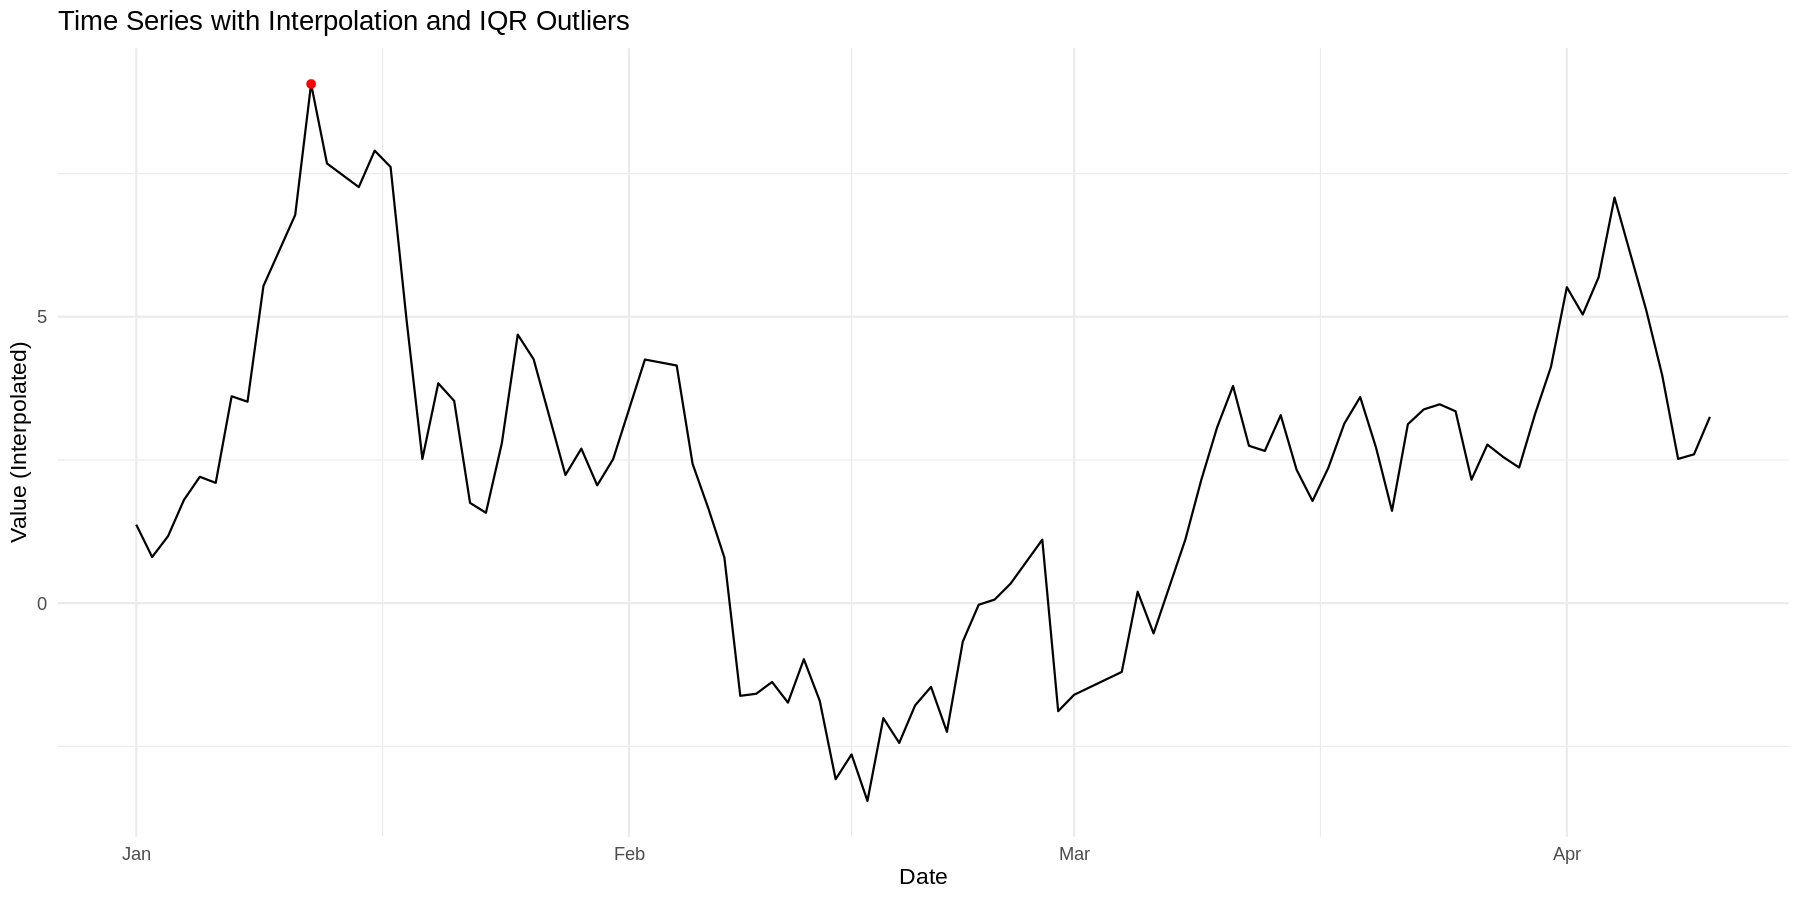

In [7]:
ggplot(df, aes(x = Date, y = Value_Interpolated)) +
  geom_line() +
  geom_point(data = df %>% filter(Outlier_IQR), color = 'red') +
  labs(title = 'Time Series with Interpolation and IQR Outliers',
       x = 'Date', y = 'Value (Interpolated)') +
  theme_minimal()
